In [351]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import math

from sympy import Point2D

In [352]:
h = 620
w = 620

def PxltoCoord(x, y, zoom, cntr_lat, cntr_lon):
    parallelMultiplier = math.cos(cntr_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier
    pointLat = cntr_lat - degreesPerPixelY * (y - h / 2)
    pointLng = cntr_lon + degreesPerPixelX * (x - w / 2)

    return [float(pointLat), float(pointLng)]


# Because of non linear transformation (going from pixel to coordinates), function has to be solved for X and Y
def CoordToPixel(pointLat, pointLon, test_lat, test_lon, zoom):
    parallelMultiplier = math.cos(test_lat * math.pi / 180)
    degreesPerPixelX = 360 / math.pow(2, zoom + 8)
    degreesPerPixelY = 360 / math.pow(2, zoom + 8) * parallelMultiplier

    Y = (test_lat - pointLat) / degreesPerPixelY + 0.5 * h
    X = (pointLon - test_lon) / degreesPerPixelX + 0.5 * w
    return X, Y

In [353]:
def find_specific_lookup(data, search_image, template_name):
    for entry in data:
        if entry["search_image"] == search_image:
            for template in entry["templates"]:
                if template["template"] == template_name:
                    return template
    return None

In [365]:
from matplotlib import image as mpimg

#get image pairs
base_path = os.path.dirname(os.getcwd())

#label path
lbl_path = os.path.join(base_path, 'Data/labels/train_template_matching.json')

#source and query images
s_img_path = os.path.join(base_path, 'Data/map_train/51.998552_4.372891.png')
q_img_path = os.path.join(base_path, 'Data/train_template_matching')

#for now source path is constant
s_img = cv2.imread(s_img_path)
print(s_img)
with open(lbl_path, 'r') as file:
    label = json.load(file)

images = []
templates = []
for file in os.listdir(q_img_path):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            q_img = cv2.imread(os.path.join(q_img_path, file))
            images.append([q_img[:, :, :3], s_img[:,:,:3]]) 
            gps = find_specific_lookup(label, '51.998552_4.372891.png', file)
            
            templates.append((q_img[:, :, :3], gps))

[[[100 100 107]
  [ 88  84 120]
  [105 113 113]
  ...
  [139 147 155]
  [ 84 104 104]
  [122 135 148]]

 [[100 100 107]
  [147 147 163]
  [187 203 215]
  ...
  [108 124 131]
  [108 131 139]
  [147 163 171]]

 [[147 147 163]
  [171 179 187]
  [165 173 181]
  ...
  [165 173 181]
  [116 131 131]
  [100 108 107]]

 ...

 [[131 159 155]
  [134 165 165]
  [134 165 165]
  ...
  [147 171 171]
  [116 139 139]
  [134 165 165]]

 [[134 165 165]
  [134 165 165]
  [ 96 151 151]
  ...
  [147 171 171]
  [116 139 139]
  [147 171 171]]

 [[134 165 165]
  [134 165 165]
  [ 96 151 151]
  ...
  [179 187 195]
  [147 171 171]
  [163 187 187]]]


In [361]:
def extract_features_for_templates(templates, source_image):
    feature_list = []
    label_list = []
    
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        print(obj)
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.998552,4.372891, 15)
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        good_matches = good_matches[:100]
        # Extract matched keypoints
        query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = query_pts.flatten()
        dst_flat = dst_pts.flatten()
        input_features = np.concatenate([src_flat, dst_flat])
        
        # Append to feature list
        feature_list.append(input_features)
        label_list.append(gps_pixel)  # GPS coordinates of this template image
    max_len = max(len(features) for features in feature_list)
    # max_len = 468
    padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return np.array(padded_features), np.array(label_list)

In [358]:
def extract_keypoints(templates, source_image):
    feature_list = []
    label_list = []
    src_flat = []
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        
        good_matches = good_matches[:100]
        # Extract matched keypoints
        query_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = dst_pts
        # dst_flat = dst_pts.flatten()
        # input_features = np.concatenate([src_flat, dst_flat])
        # 
        # # Append to feature list
        # feature_list.append(input_features)
        # label_list.append(gps_pixel)  # GPS coordinates of this template image
    # max_len = max(len(features) for features in feature_list)
    # # max_len = 468
    # padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return src_flat

In [363]:
print(templates)

[(array([[[108,  91,  84],
        [ 50,  35,  27],
        [ 66,  49,  45],
        ...,
        [ 58, 131, 115],
        [ 67, 132, 115],
        [ 77, 139, 126]],

       [[163, 151, 139],
        [ 74,  67,  58],
        [ 50,  35,  27],
        ...,
        [ 62, 124, 108],
        [ 77, 139, 126],
        [ 84, 147, 131]],

       [[108,  95,  91],
        [108,  95,  91],
        [ 41,  41,  30],
        ...,
        [ 77, 139, 126],
        [ 84, 147, 131],
        [ 77, 139, 126]],

       ...,

       [[147, 147, 150],
        [123, 130, 138],
        [ 99, 104, 119],
        ...,
        [ 50,  35,  16],
        [ 50,  35,  27],
        [ 23,  22,   4]],

       [[ 86,  86, 107],
        [147, 147, 150],
        [ 42,  67,  50],
        ...,
        [ 50,  35,  27],
        [ 23,  22,   4],
        [ 66,  57,  54]],

       [[ 39,  54,  39],
        [135, 135, 151],
        [ 67,  67,  67],
        ...,
        [ 74,  67,  58],
        [175, 163, 155],
        [228, 228, 228

In [359]:
###### DB SCAN

In [366]:
X_train, y_train = extract_features_for_templates(templates, s_img)

{'template': '51.991624_4.373863.png', 'bounding_box': [[51.99089734398529, 51.99248265601471], [4.37246796295166, 4.37547203704834]], 'gps_coords': [51.99169, 4.37397]}
{'template': '51.991625_4.371242.png', 'bounding_box': [[51.99089834398529, 51.99248365601471], [4.3698469629516605, 4.37285103704834]], 'gps_coords': [51.991691, 4.371349]}
{'template': '51.991643_4.37566.png', 'bounding_box': [[51.99091634398529, 51.99250165601471], [4.37426496295166, 4.37726903704834]], 'gps_coords': [51.991709, 4.375767]}
{'template': '51.991647_4.362484.png', 'bounding_box': [[51.99092034398529, 51.99250565601471], [4.36108896295166, 4.36409303704834]], 'gps_coords': [51.991713, 4.362591]}
{'template': '51.991667_4.369149.png', 'bounding_box': [[51.990940343985294, 51.99252565601471], [4.36775396295166, 4.37075803704834]], 'gps_coords': [51.991733, 4.369256]}
{'template': '51.991691_4.3841.png', 'bounding_box': [[51.99096434398529, 51.99254965601471], [4.38270496295166, 4.38570903704834]], 'gps_co

In [234]:
keypoints_train = extract_keypoints(templates, s_img)

66


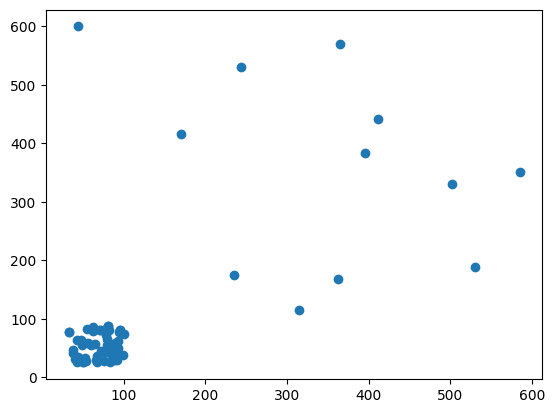

In [250]:
print(len(keypoints_train))

plt.scatter(keypoints_train[:, 0], keypoints_train[:, 1])

In [298]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

def cluster(keypoints_train):

    #keypoints_train = extract_keypoints(templates, s_img)
    db = DBSCAN(eps=0.5, min_samples=5).fit(keypoints_train/620)
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    # print(n_clusters_)
    return labels

In [299]:
def retrieve_relevant_points(keypoints_train, labels):
    cluster = []
    for i in range(len(keypoints_train)):
        if labels[i] == 0:
            cluster.append(keypoints_train[i])
    return cluster

In [300]:
def get_pixel_average(coords):
    return np.average(coords, axis=0)

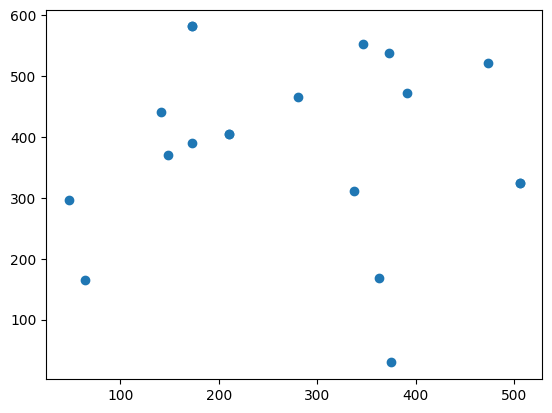

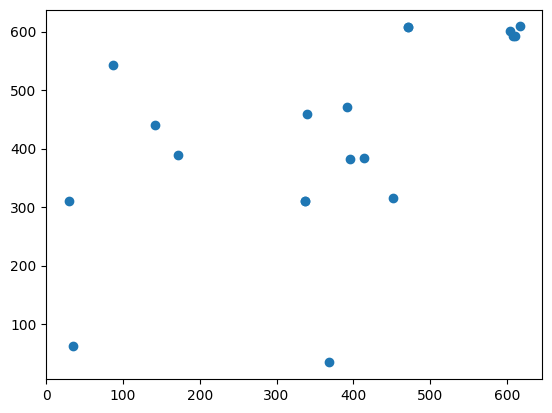

KeyboardInterrupt: 

In [308]:
from haversine import haversine, Unit

distance = 0
for temp in templates:
    keys = extract_keypoints([temp], s_img)
    labels = cluster(keys)
    points = retrieve_relevant_points(keys, labels)
    avg_points = get_pixel_average(points)
    
    predicted_coords = PxltoCoord(avg_points[0], avg_points[1], 15, 51.999080, 4.373749)
    # print(temp[1]['gps_coords'])
    actual_coords = temp[1]['gps_coords']
    distance += haversine(predicted_coords, actual_coords, unit=Unit.METERS)
    if haversine(predicted_coords, actual_coords, unit=Unit.METERS) > 500:
        plt.scatter(keys[:, 0], keys[:, 1])
        plt.show()
        
    # print(haversine(predicted_coords, actual_coords, unit=Unit.METERS))
print(distance/len(templates))
    

In [367]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf
# Define the model
def build_model(input_size):
    model = models.Sequential([
        layers.Input(shape=(input_size,)),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(2)  # Predict latitude and longitude
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.85),  # Tune learning rate if necessary
                  loss='mean_squared_error')
    return model


In [342]:
print(X_train.shape[1])

400


In [369]:
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)

# Initialize and train the model
pca = PCA(n_components=100)  # Reduce to 100 dimensions
X_train_pca = pca.fit_transform(X_train)
model = build_model(X_train.shape[1])
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[lr_scheduler, early_stopping])


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 96068.4219 - val_loss: 41351.7852 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15238.3506 - val_loss: 30976.3320 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8902.0684 - val_loss: 21085.2051 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5346.3359 - val_loss: 19569.6250 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4631.4536 - val_loss: 16214.8535 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2864.6560 - val_loss: 14846.2686 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2178.4355 - val_loss: 9889.7998 - learning_rate: 0.0010
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1894.1737 - val_loss: 10090.8242 - learning_rate: 0.0010
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1500.8271 -

In [371]:
#get image pairs
base_path = os.path.dirname(os.getcwd())

#label path
lbl_path = os.path.join(base_path, 'Data/labels/test_template_matching.json')

#source and query images
s_img_path = os.path.join(base_path, 'Data/map_train/51.998552_4.372891.png')
q_img_path = os.path.join(base_path, 'Data/test_template_matching')

#for now source path is constant
s_img = cv2.imread(s_img_path)

with open(lbl_path, 'r') as file:
    label = json.load(file)

images = []
templates = []
for file in os.listdir(q_img_path):
    if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            q_img = cv2.imread(os.path.join(q_img_path, file))
            images.append([q_img[:, :, :3], s_img[:,:,:3]]) 
            gps = find_specific_lookup(label, '51.998552_4.372891.png', file)
            
            templates.append((q_img[:, :, :3], gps))

In [372]:
def extract_features_for_test(templates, source_image):
    feature_list = []
    label_list = []
    
    sift = cv2.SIFT_create()
    kp_source, des_source = sift.detectAndCompute(source_image, None)
    
    for template, obj in templates:
        kp_template, des_template = sift.detectAndCompute(template, None)
        gps_coords = obj['gps_coords']
        gps_pixel = CoordToPixel(gps_coords[0], gps_coords[1], 51.999080, 4.373749, 15)
        
        # Match features
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des_template, des_source, k=2)
        
        # Lowe's ratio test
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)
        good_matches = good_matches[:100]
        # Extract matched keypoints
        src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
        dst_pts = np.float32([kp_source[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
        
        # Flatten and combine features
        src_flat = src_pts.flatten()
        dst_flat = dst_pts.flatten()
        input_features = np.concatenate([src_flat, dst_flat])
        
        # Append to feature list
        feature_list.append(input_features)
        label_list.append(gps_pixel)  # GPS coordinates of this template image
    max_len = max(len(features) for features in feature_list)
    # max_len = 504
    padded_features = [np.pad(features, (0, max_len - len(features))) for features in feature_list]

    return np.array(padded_features), np.array(label_list)

In [373]:
X_test, y_test = extract_features_for_test(templates, s_img)

In [374]:
print(X_test.shape, X_train.shape)

(300, 400) (1000, 400)


In [376]:
from haversine import haversine, Unit
distance = 0
# Assuming PCA was fitted on X_train
X_test_pca = pca.transform(X_test)  # Apply the same PCA transformation to X_test

for i, test_input in enumerate(X_test):
    y_trinna = PxltoCoord(y_test[i][0], y_test[i][1], 15, 51.998552, 4.372891)
    # print(test_input.shape)
    point2 = model.predict(test_input.reshape(1, -1))
    # print(point2)
    point2 = PxltoCoord(point2[0][0], point2[0][1], 15, 51.998552,4.372891)
    # print(point2)
    # print(point2)
    distance += haversine(y_trinna, point2, unit=Unit.METERS)
print(len(X_test))
print(distance/len(X_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━